# Importing the necessarry python packages

In [22]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import matplotlib as mpl
import glob
import matplotlib
from scipy.io import FortranFile
import struct
import os


shark_dir     =  os.environ["SHARK_LITE_DIR"]# Add the test suite path here
bin_dir       =  shark_dir+'/bin'       # Add the bin directory here
suite_dir     =  shark_dir+'/test/test-suite'
NUM_THREAD    = 2 # This depends on your machine, this is the number of threads you want to use with openmp

# Default compilation options for the tests

In [23]:
OPENMP     = 1    # We use the openmp speedup
SOLVER     = 2    # HLLD
SOLVERDUST = 0    # Huang & Bai 2021, if applicable ie if dust is included
RESOLUTION = 2048 # Default resolution for the 1D tests

default_compils={'OPENMP':OPENMP,"NUM_THREAD":NUM_THREAD,'SOLVER':SOLVER,'SOLVERDUST':SOLVERDUST,"RESOLUTION":RESOLUTION}

# Functions to read the data from shark

In [32]:
def read_var(filename,varname,size):
    f=open(filename+"/"+varname, "rb")
    dat = np.fromfile(f, dtype=np.float64, count=size, sep='')
    return dat

def read_parameter_file(fname="",evaluate=True,verbose=True,delimiter="="):
    # Read info file and create dictionary
    try:
        with open(fname) as f:
            content = f.readlines()
        f.close()
    except IOError:
        # Clean exit if the file was not found
        if verbose:
            print("File not found: "+fname)
        return 0
    infos={}
    for line in content:
        sp = line.split(delimiter)
        #print(sp)
        if len(sp) > 1:
            if evaluate:
                try:
                    infos[sp[0].strip()] = eval(sp[1].strip())
                except (NameError,SyntaxError):
                    infos[sp[0].strip()] = sp[1].strip()
            else:
                infos[sp[0].strip()] = sp[1].strip()
    return infos

def read_output(number,path='.'):
    
    if(number==-1):
        filelist = sorted(glob.glob(path+"/output*"))
        number = filelist[-1].split("_")[-1]
    print('Reading output '+str(number))
    data={}
    filename= path+"/output_"+ str(number).zfill(5)
    infos=read_parameter_file(fname=filename+'/info.dat')
    data['infos']=infos
    for key in infos:
        print(key+' = ',infos[key])
    
    NX          = infos["NX"]
    NY          = infos["NY"]
    NDUST       = infos["ndust"]
    GEOM        = infos['GEOM']
    GRIDSPACE   = infos['GRIDSPACE']
    data['x']   = read_var(filename,'x',NX*NY)
    
    if(NY>1):
        data['y']   = read_var(filename,'y',NX*NY)
        data["xx"]  = np.linspace(np.amin(data["x"]),np.amax(data["x"]),NX)
        data["yy"]  = np.linspace(np.amin(data["y"]),np.amin(data["y"]),NY)
        data["xx"]  = np.linspace(0,1,NX)
        data["yy"]  = np.linspace(0,1,NY)
    
    vx   = read_var(filename,'v'  , NX*NY)
    vy   = read_var(filename,'vy' , NX*NY)
    P    = read_var(filename,'P'  , NX*NY)
    rho  = read_var(filename,'rho', NX*NY)

    if(NDUST>0):
        rhod   = read_var(filename,'rhod',  NX*NY*NDUST)
        rhod_tot   = read_var(filename,'rhod_tot',  NX*NY*NDUST)
        vdx    = read_var(filename,'vd'  ,  NX*NY*NDUST)
        vdy    = read_var(filename,'vdy' ,  NX*NY*NDUST)
        sd     = read_var(filename,'sd',  NX*NY*NDUST)
        if(NDUST>1):
            for idust in range(NDUST):
                if(NY>1):
                    data['rhod'] = np.reshape(rhod_tot,(NY,NX),order = "C").T
                    data['rhod' + str(idust+1)]  = np.reshape(rhod[(idust)* NX * NY:(idust+1)*NX*NY],(NY,NX),order  = "C").T
                    data['vdx'  + str(idust+1)]  = np.reshape(vdx[(idust) * NX * NY:(idust+1)*NX*NY],(NY,NX),order  = "C").T
                    data['vdy'  + str(idust+1)]  = np.reshape(vdx[(idust) * NX * NY:(idust+1)*NX*NY],(NY,NX),order  = "C").T
                    data['sd'  + str(idust+1)]   = np.reshape(sd[(idust) * NX * NY:(idust+1)*NX*NY],(NY,NX),order  = "C").T
                else:
                    data['rhod' + str(idust+1)]  = rhod[(idust)* NX:(idust+1) * NX]
                    data['vdx'  + str(idust+1)]  = vdx[(idust) * NX:(idust+1) * NX]
                    data['vdy'  + str(idust+1)]  = vdy[(idust) * NX:(idust+1) * NX]
                    data['sd'  + str(idust+1)]   = sd[(idust) * NX:(idust+1) * NX]
        else:
            if(NY>1):
                data['rhod'] = np.reshape(rhod,(NY,NX),order = "C").T
                data['vdx']  = np.reshape(vdx,(NY,NX),order = "C") .T
                data['vdy']  = np.reshape(vdy,(NY,NX),order = "C") .T   
                data['sd']   = np.reshape(sd,(NY,NX),order = "C") .T   
                
            else:
                data['rhod'] = rhod
                data['vdx']  = vdx
                data['vdy']  = vdy
                data['sd']   = sd

    if(NY>1):     
        data['rho'] = np.reshape(rho,(NY,NX),order = "C").T
        data['vx']  = np.reshape(vx ,(NY,NX),order = "C").T
        data['vy']  = np.reshape(vy ,(NY,NX),order = "C").T
    else:
        data['rho'] = rho
        data['vx']  = vx
        data['vy']  = vy
        data['P']   = P
     

    if(NX==1):
        data['rhod'] = rhod
        data['rho']  = rho[0]
        data['sd']   = read_var(filename,'sd',  NX*NY*NDUST)

    if(GEOM==2): 
        rmin = np.amin(data['x'])
        rmax = np.amax(data['x'])
        r=np.linspace(rmin,rmax,NX)
        if(GRIDSPACE==1):
            r=np.logspace(np.log10(rmin),np.log10(rmax),NX)
        data['r']=r
        data['theta']=np.linspace(0,2.*np.pi,NY)
    if(GEOM==4): 
        rmin = np.amin(data['x'])
        rmax = np.amax(data['x'])
        r=np.linspace(rmin,rmax,NX)
        if(GRIDSPACE==1):
            r=np.logspace(np.log10(rmin),np.log10(rmax),NX)
        data['r']=r
        data['z']=data['y']
    return data

# Functions to run the tests

In [25]:
def run_test(test='Sod-tube',options=default_compils,visu=True,flag_change=None):
    
    if(test=="Sod-tube"):
        flags="SETUP=SOD NX="+str(options["RESOLUTION"])+" NY=1 NGHOST=2 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER="+str(options["SOLVER"])
        if(flag_change is not None):
            flags=flag_change
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark sod.nml')
        data_ana = np.loadtxt(suite_dir+'/'+test+'/solution.dat')
        
        x_ana    = data_ana[:,1]
        rho_ana  = data_ana[:,3]
        u_ana    = data_ana[:,2]
        p_ana    = data_ana[:,4]
        T_ana    = data_ana[:,5]*1.2027e-8/2.5
        
        data=read_output(-1)
        plt.plot(x_ana,rho_ana,color='k',label='analytical solution')
        plt.plot(data['x'],data['rho'],color='r',linestyle='dashed',label='SHARK')
        plt.xlabel("x")
        plt.ylabel("density [code units]")
        plt.legend()
        plt.show()
        plt.plot(x_ana,u_ana,color='k',label='analytical solution')
        plt.plot(data['x'],data['vx'],color='r',linestyle='dashed',label='SHARK')
        plt.xlabel("x")
        plt.ylabel("Velocity [code units]")
        plt.legend()
        plt.show()
        
    if(test=="DUSTYWAVE"):
        flags="SETUP=DUSTYWAVE NX="+str(options["RESOLUTION"])+" NY=1 NDUST=1 NGHOST=2 NDUSTPSCAL=1 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER="+str(options["SOLVER"])
        if(flag_change is not None):
            flags=flag_change
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')

        #Wave with K = 1000
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark wave1000.nml')
        data_ana    = np.loadtxt(suite_dir+'/'+test+'/dustywave-K1000.dat')
        x_ana       = data_ana[:,0]
        vg_ana      = data_ana[:,1]
        vd_ana      = data_ana[:,2]
        rhog_ana    = data_ana[:,3]
        rhod_ana    = data_ana[:,4]
        data=read_output(-1)
        
        
        plt.plot(x_ana,vg_ana,color='k',label='analytical solution - Gas')
        plt.plot(data['x'],data['vx'],color='r',label='SHARK - Gas')
        plt.xlabel("x")
        plt.ylabel("Velocity gas [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()    
        
        plt.plot(x_ana,vd_ana,color='k',label='analytical solution - Dust')
        plt.plot(data['x'],data['vdx'],color='b',linestyle='dashed',label='SHARK - Dust')
        plt.xlabel("x")
        plt.ylabel("Velocity dust [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()        
        
        #Wave with K = 100
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark wave100.nml')
        data_ana = np.loadtxt(suite_dir+'/'+test+'/dustywave-K100.dat')
        x_ana       = data_ana[:,0]
        vg_ana      = data_ana[:,1]
        vd_ana      = data_ana[:,2]
        rhog_ana    = data_ana[:,3]
        rhod_ana    = data_ana[:,4]
        data=read_output(-1)
        
        
        plt.plot(x_ana,vg_ana,color='k',label='analytical solution - Gas')
        plt.plot(data['x'],data['vx'],color='r',label='SHARK - Gas')
        plt.xlabel("x")
        plt.ylabel("Velocity gas [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()    
        
        plt.plot(x_ana,vd_ana,color='k',label='analytical solution - Dust')
        plt.plot(data['x'],data['vdx'],color='b',linestyle='dashed',label='SHARK - Dust')
        plt.xlabel("x")
        plt.ylabel("Velocity dust [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()        
        
        #Wave with K = 50
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark wave50.nml')
        data_ana = np.loadtxt(suite_dir+'/'+test+'/dustywave-K50.dat')
        x_ana       = data_ana[:,0]
        vg_ana      = data_ana[:,1]
        vd_ana      = data_ana[:,2]
        rhog_ana    = data_ana[:,3]
        rhod_ana    = data_ana[:,4]
        data=read_output(-1)
        
        
        plt.plot(x_ana,vg_ana,color='k',label='analytical solution - Gas')
        plt.plot(data['x'],data['vx'],color='r',label='SHARK - Gas')
        plt.xlabel("x")
        plt.ylabel("Velocity gas [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()    
        
        plt.plot(x_ana,vd_ana,color='k',label='analytical solution - Dust')
        plt.plot(data['x'],data['vdx'],color='b',linestyle='dashed',label='SHARK - Dust')
        plt.xlabel("x")
        plt.ylabel("Velocity dust [code units]")
        plt.ylim(-1e-4,1e-4)
        plt.legend()
        plt.show()        
        
    if(test=="SI_BA"):
        flags="SETUP=SI NX="+str(options["RESOLUTION"])+" NY="+str(options["RESOLUTION"])+" NDUST=1 NGHOST=2 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER=2 SOLVERDUST=0"
        if(flag_change is not None):
            flags=flag_change
        print ('You are compiling with the options '+ flags )
        
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark si.nml')
        data=read_output(-1)
        fig,ax=plt.subplots(1,1)
        fig.set_size_inches(10,10)
        plt.contourf(data["xx"],data["yy"],np.log10(data["rhod"].T),levels=np.linspace(-2,1,100),cmap='magma',extend='both')
        plt.colorbar(label='Dust density [code unit]')
        plt.title('t = '+str(round(data["infos"]["time"],2))+' $\\Omega^{-1}$')
        plt.xlabel("x")
        plt.ylabel("y")
        #plt.legend()
        ax.set_aspect('equal')
        plt.show()
        plt.close("all")
    if(test=="PSI_B"):
        flags="SETUP=SI NX="+str(options["RESOLUTION"])+" NY="+str(options["RESOLUTION"])+" NDUST=16 NGHOST=2 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER=2 SOLVERDUST=0"
        if(flag_change is not None):
            flags=flag_change
        print ('You are compiling with the options '+ flags )
        
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark si.nml')
        data=read_output(-1)
        fig,ax=plt.subplots(1,1)
        fig.set_size_inches(10,10)
        z=np.log10(data["rhod"].T)
        plt.contourf(data["xx"],data["yy"],z,levels=np.linspace(np.amin(z),np.amax(z),100),cmap='magma',extend='both')
        plt.colorbar(label='Dust density [code unit]')
        plt.title('t = '+str(round(data["infos"]["time"],2))+' $\\Omega^{-1}$')
        plt.xlabel("x")
        plt.ylabel("y")
        #plt.legend()
        ax.set_aspect('equal')
        plt.show()
        plt.close("all")
                
        
    if(test=="DISK_EQ"):
        flags="SETUP=disk_polar NX=64 NY=64 NDUST=0 GEOM=2 GRIDSPACE=1 NGHOST=2 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER=1"
        if(flag_change is not None):
            flags=flag_change 
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark disk.nml')
        data=read_output(-1)
        
        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        levels = np.linspace(-3, 3, 1000)
        im=plt.contourf(data['theta'],data['r'],np.log10(data['rho']),levels=levels,cmap='inferno')
        plt.colorbar(im,label='Column density [g /cm2]',extend='both')
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
    if(test=="DISK_EDGE-ON"):
        flags="SETUP=disk_edge_on NX=128 NY=128 NDUST=0 GEOM=4 GRIDSPACE=1 NGHOST=2 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER=1"
        if(flag_change is not None):
            flags=flag_change 
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark disk.nml')
        data=read_output(-1)


        fig,ax=plt.subplots()
        fig.set_size_inches(10,10/3)
        levels = np.linspace(np.amin(np.log10(data['rho'])),np.amax(np.log10(data['rho'])) , 1000)

        im=plt.contourf(data["r"],data["yy"],np.log10(data['rho'].T),levels=levels,cmap='inferno')
        plt.colorbar(im,label='Column density [g /cm2]',extend='both')
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
        
    if(test=="DISK_EQ_1D"):
        flags="SETUP=disk_1D NX=1024 NY=1 NDUST=0 GEOM=2 GRIDSPACE=1 NGHOST=2 OPENMP=0 DEBUG=0 SOLVER=1"
        if(flag_change is not None):
            flags=flag_change
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark disk.nml')
        data0=read_output(1)
        data=read_output(-1)
        
        fig,ax=plt.subplots()
        fig.set_size_inches(10,10)
        plt.loglog(data['x'],data0['rho'],color='r',label='t=0')        
        plt.loglog(data['x'],data['rho'],color='r',label='tf')
        plt.xlabel("x")
        plt.ylabel("y")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
    if(test=="DISK_S7-1"):
        flags="SETUP=disk_polar NX=64 NY=64 NDUST=0 GEOM=2 GRIDSPACE=1 NGHOST=2 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER=1"
        if(flag_change is not None):
            flags=flag_change
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark disk_accrete.nml')
        data=read_output(-1)
        
        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        levels = np.linspace(-3, 3, 1000)
        im=plt.contourf(data['theta'],data['r'],np.log10(data['rho']),levels=levels,cmap='inferno')
        plt.colorbar(im,label='Column density [g /cm2]',extend='both')
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
    if(test=="DISK_DUST"):
        flags="SETUP=disk_polar NX="+str(options["RESOLUTION"])+" NY="+str(options["RESOLUTION"])+" NDUST=1 GEOM=2 GRIDSPACE=1 NGHOST=2 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER="+str(options["SOLVER"])+" SOLVERDUST="+str(options["SOLVERDUST"])
        if(flag_change is not None):
            flags=flag_change
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark disk_dust.nml')
        data=read_output(-1)
        
        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        minv = np.amin(np.log10(data['rho']))
        maxv = np.amax(np.log10(data['rho']))
        levels = np.linspace(minv, maxv, 1000)
        im=plt.contourf(data['theta'],data['r'],np.log10(data['rho']),levels=levels,cmap='inferno')
        plt.colorbar(im,label='Column density [g /cm2]',extend='both')
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
        
        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        minv = np.amin(np.log10(data['rhod']))
        maxv = np.amax(np.log10(data['rhod']))
        levels = np.linspace(minv, maxv, 1000)
        im=plt.contourf(data['theta'],data['r'],np.log10(data['rhod']),levels=levels,cmap='inferno')
        plt.colorbar(im,label='Dust column density [g /cm2]',extend='both')
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
        
        
        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        levels = np.linspace(-1, 1, 1000)
        im=plt.contourf(data['theta'],data['r'],np.log10(data['rhod']/data['rho']*100),levels=levels,cmap='seismic')
        plt.colorbar(im,label='Dust-to-gas ratio variations',extend='both')
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
        
    if(test=="DISK_DUST_STEP"):
        flags="SETUP=disk_polar NX="+str(options["RESOLUTION"])+" NY="+str(options["RESOLUTION"])+" NDUST=1 NDUSTPSCAL=1 GEOM=2 GRIDSPACE=1 NGHOST=2 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER="+str(options["SOLVER"])+" SOLVERDUST="+str(options["SOLVERDUST"])
        if(flag_change is not None):
            flags=flag_change
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark disk_dust.nml')
        data=read_output(-1)
        
        fig,ax=plt.subplots()
        fig.set_size_inches(10,10)
        minv = np.amin(np.log10(data['rho']))
        maxv = np.amax(np.log10(data['rho']))
        levels = np.linspace(minv, maxv, 1000)
        im=plt.contourf(data['theta'],data['r'],np.log10(data['rho']),levels=levels,cmap='inferno')
        plt.colorbar(im,label='Column density [g /cm2]',extend='both')
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
        
        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        minv = np.amin(np.log10(data['rhod']))
        maxv = np.amax(np.log10(data['rhod']))
        levels = np.linspace(minv, maxv, 1000)
        im=plt.contourf(data['theta'],data['r'],np.log10(data['rhod']),levels=levels,cmap='inferno')
        plt.colorbar(im,label='Dust column density [g /cm2]',extend='both')
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
        
        
        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        levels = np.linspace(-1, 1, 1000)
        im=plt.contourf(data['theta'],data['r'],np.log10(data['rhod']/data['rho']*100),levels=levels,cmap='seismic')
        plt.colorbar(im,label='Dust-to-gas ratio variations',extend='both')
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)     
        
        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        minv = np.amin((data['sd']))
        maxv = np.amax((data['sd']))
        levels = np.linspace(minv, maxv, 1000)
        im=plt.contourf(data['theta'],data['r'],(data['sd']),levels=levels,cmap='inferno')
        plt.colorbar(im,label='log(sdust) [cm]',extend='both')
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
    if(test=="DISK_DUST_ACC"):
        flags="SETUP=disk_polar NX="+str(options["RESOLUTION"])+" NY="+str(options["RESOLUTION"])+" NDUST=1 GEOM=2 GRIDSPACE=1 NGHOST=2 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER="+str(options["SOLVER"])+" SOLVERDUST="+str(options["SOLVERDUST"])
        if(flag_change is not None):
            flags=flag_change        
        print ('You are compiling with the options '+ flags )
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark disk_dust.nml')
        data=read_output(-1)
        r     = data['r']

        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        minv = np.amin(np.log10(data['rho']))
        maxv = np.amax(np.log10(data['rho']))
        levels = np.linspace(minv, maxv, 1000)
        im=plt.contourf(data['theta'],r,np.log10(data['rho']),levels=levels,cmap='inferno')
        plt.colorbar(im,label='Column density [g /cm2]',extend='both')
        ax.set_ylim(0, r[-1])
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
        
        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        minv = np.amin(np.log10(data['rhod']))
        maxv = np.amax(np.log10(data['rhod']))
        levels = np.linspace(minv, maxv, 1000)
        im=plt.contourf(data['theta'],r,np.log10(data['rhod']),levels=levels,cmap='inferno')
        plt.colorbar(im,label='Dust column density [g /cm2]',extend='both')
        ax.set_ylim(0, r[-1])
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
        
        
        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(10,10)
        levels = np.linspace(-1, 1, 1000)
        
        im=plt.contourf(data['theta'],r,np.log10(data['rhod']/data['rho']*100),levels=levels,cmap='seismic')
        plt.colorbar(im,label='Dust-to-gas ratio variations',extend='both')
        ax.set_ylim(0, r[-1])
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24*1000)
        plt.title('t=' +str(round(t100,2))+' T$_{100}$')
        plt.gcf().set_dpi(1024)
        fig.set_dpi(1024)
        
    if(test=="DISK_PLANET"):
        flags="SETUP=disk_polar NX="+str(options["RESOLUTION"])+" NY="+str(options["RESOLUTION"])+" NDUST=0 GEOM=2 GRIDSPACE=0 NGHOST=2 OPENMP="+str(options["OPENMP"])+" DEBUG=0 SOLVER="+str(options["SOLVER"])+" SOLVERDUST="+str(options["SOLVERDUST"])
        if(flag_change is not None):
            flags=flag_change        
        print ('You are compiling with the options '+ flags )
        
        os.chdir(bin_dir)
        os.system("make clean && make "+flags)
        os.chdir(suite_dir+'/'+test)
        os.system('rm -rf output_*')
        os.system("export OMP_NUM_THREADS="+str(options["NUM_THREAD"])+";"+bin_dir+'/shark disk_planet.nml')
        
        data0=read_output(1)
        data=read_output(-1)

        fig,ax=plt.subplots(subplot_kw=dict(projection='polar'))
        fig.set_size_inches(4,4)

        
        r     = data['r']
        data_Z= np.log10(data['rho'])#-np.log10(data0['rho'])
        minv  = np.amin(data_Z)
        maxv  = np.amax(data_Z)
        levels = np.linspace(minv,maxv, 200)
        #data_Z=data['rho']

        im=plt.contourf(data['theta'],r,data_Z,levels=levels,cmap='inferno')
        plt.colorbar(im,label='Column density variation',extend='both')
        #ax.set_rorigin(0.5)
        ax.set_ylim(0, r[-1])
        plt.xlabel("x")
        plt.ylabel("y")
        ax.axis("off")
        t100= data['infos']['time']*data['infos']['unit_t']/(365.25*3600*24)
        #plt.title('t=' +str(round(t100,2))+' year')
        #plt.gcf().set_dpi(1024)
        #fig.set_dpi(1024)

# Tests

## Test 1 : Sod-tube

This is the first test to be ran, this is a simple 1D simulation of a propagating shock. This test has an analytical solution and serves as a validation of the gas.

You are compiling with the options SETUP=SOD NX=2048 NY=1 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2
Reading output 00003
nvar =  5
ndust =  0
ndustpscal =  0
NX =  2048
NY =  1
GEOM =  0
GRIDSPACE =  0
time =  0.245094188353975
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0


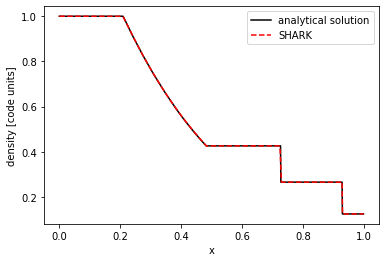

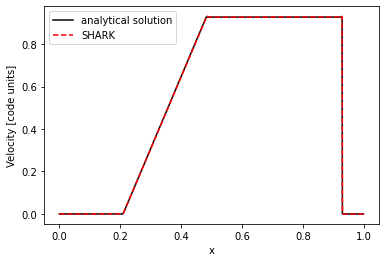

In [33]:
run_test(test='Sod-tube')

# Test 2 : Dustywave

Here we test the propagation of a gas & dust sound-wave or DUSTYWAVE. The drag between the gas and the dust generates a damping of the wave. The stronger the coupling is, the weaker the damping. Here we test 3 values for the drag coefficient K that controls the value of the stopping time : 50 (weak coupling), 100 (intermediate coupling) and 1000 (strong coupling). This test is 1D, but we compile the code with one dust species so we validate both the gas and the dust dynamics.

You are compiling with the options SETUP=DUSTYWAVE NX=2048 NY=1 NDUST=1 NGHOST=2 NDUSTPSCAL=1 OPENMP=1 DEBUG=0 SOLVER=2
Reading output 00004
nvar =  10
ndust =  1
ndustpscal =  1
NX =  2048
NY =  1
GEOM =  0
GRIDSPACE =  0
time =  4.50000830935489
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0


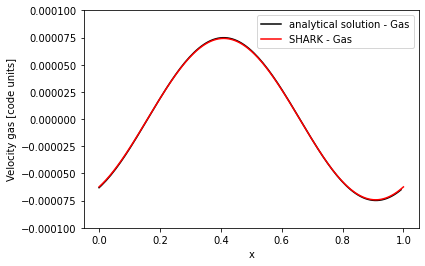

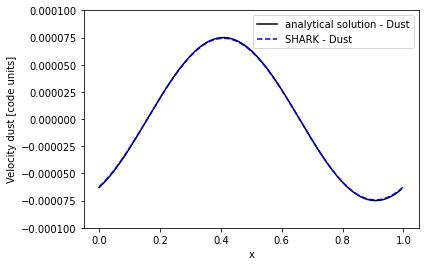

Reading output 00004
nvar =  10
ndust =  1
ndustpscal =  1
NX =  2048
NY =  1
GEOM =  0
GRIDSPACE =  0
time =  4.5000437957155
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0


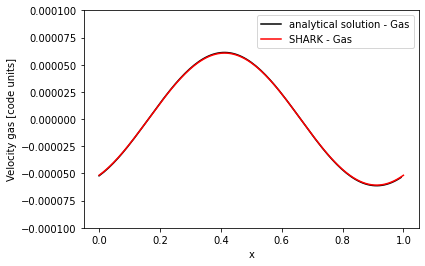

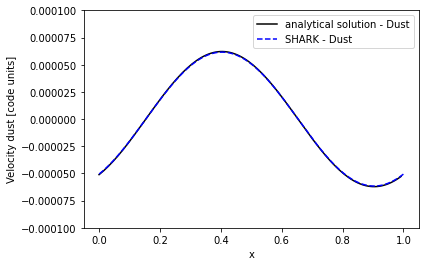

Reading output 00004
nvar =  10
ndust =  1
ndustpscal =  1
NX =  2048
NY =  1
GEOM =  0
GRIDSPACE =  0
time =  4.50007778132959
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0


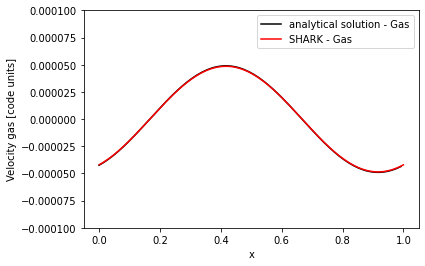

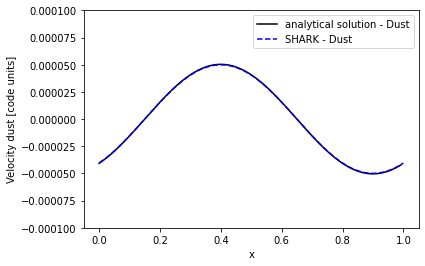

In [37]:
run_test(test='DUSTYWAVE')

# Test 5 : Streaming instability BA test

This is the classical BA test from Johansen & Youdin 2007, only for the test we use a very low resolution to minimize the numerical coast since this is only a test. Fell free to increase the resolution at will to get nicer results.

You are compiling with the options SETUP=SI NX=64 NY=64 NDUST=1 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2 SOLVERDUST=0
Reading output 00012
nvar =  9
ndust =  1
ndustpscal =  0
NX =  64
NY =  64
GEOM =  0
GRIDSPACE =  0
time =  500.002854925192
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0


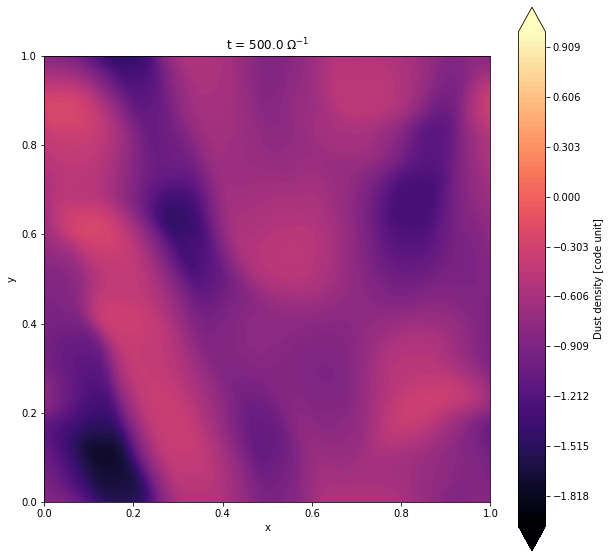

In [40]:
options={'OPENMP':1,"NUM_THREAD":4,'SOLVER':0,'SOLVERDUST':0,"RESOLUTION":128}
run_test(test='SI_BA',options=options,flag_change='SETUP=SI NX=64 NY=64 NDUST=1 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2 SOLVERDUST=0')

You are compiling with the options SETUP=SI NX=128 NY=128 NDUST=16 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2 SOLVERDUST=0
Reading output 00007
nvar =  69
ndust =  16
ndustpscal =  0
NX =  128
NY =  128
MHD =  0
GEOM =  0
TURB =  0
GRIDSPACE =  0
time =  147.46755182481
unit_t =  1.0
unit_d =  1.0
unit_l =  1.0
unit_v =  1.0
unit_p =  1.0
charging =  0


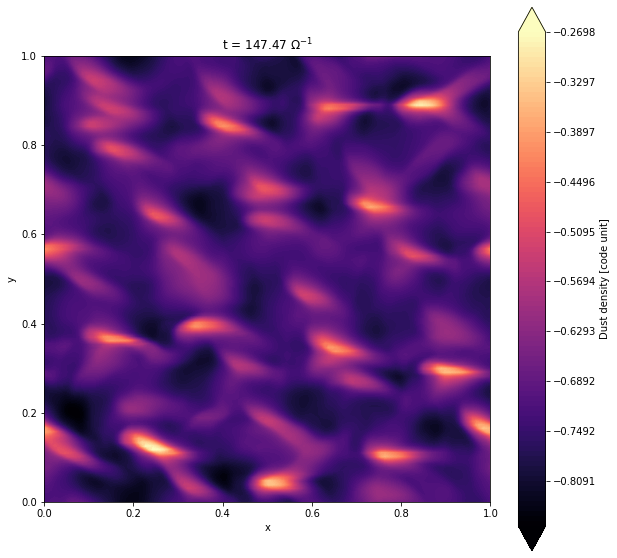

In [71]:
options={'OPENMP':1,"NUM_THREAD":4,'SOLVER':0,'SOLVERDUST':0,"RESOLUTION":128}
run_test(test='PSI_B',options=options,flag_change='SETUP=SI NX=128 NY=128 NDUST=16 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=2 SOLVERDUST=0')

# Test 6: Protoplanetary disk at equilibrium

This tests the polar geometry implemented in the code. This is a simple accretion disk without any phyisical viscosity (only the numerical one), so the disk must be stable for quite some time. 

In [13]:
run_test(test='DISK_EQ')

You are compiling with the options SETUP=disk_polar NX=64 NY=64 NDUST=0 GEOM=2 GRIDSPACE=1 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=1
Reading output 00012
nvar =  5
ndust =  0
ndustpscal =  0
NX =  64
NY =  64
MHD =  0
GEOM =  2
TURB =  0
GRIDSPACE =  1
time =  3447.56090876124
unit_t =  5029895.63261133
unit_d =  5.92592592592593e-07
unit_l =  15000000000000.0
unit_v =  2982169.23284601
unit_p =  8893333333333.33
charging =  0


In [39]:
run_test(test='DISK_EQ_1D')

You are compiling with the options SETUP=disk_1D NX=1024 NY=1 NDUST=0 GEOM=2 GRIDSPACE=1 NGHOST=2 OPENMP=0 DEBUG=0 SOLVER=1


FileNotFoundError: [Errno 2] No such file or directory: '/Users/ul264359/Documents/codes/dev/SHARK_FORKS/shark_lite/test/test-suite/DISK_EQ_1D'

You are compiling with the options SETUP=disk_edge_on NX=128 NY=128 NDUST=0 GEOM=4 GRIDSPACE=1 NGHOST=2 OPENMP=1 DEBUG=0 SOLVER=1
Reading output 00002
nvar =  5
ndust =  0
ndustpscal =  0
NX =  128
NY =  128
MHD =  0
GEOM =  4
TURB =  0
GRIDSPACE =  1
time =  120.494962883841
unit_t =  5029895.63261133
unit_d =  5.92592592592593e-07
unit_l =  15000000000000.0
unit_v =  2982169.23284601
unit_p =  8893333333333.33
charging =  0


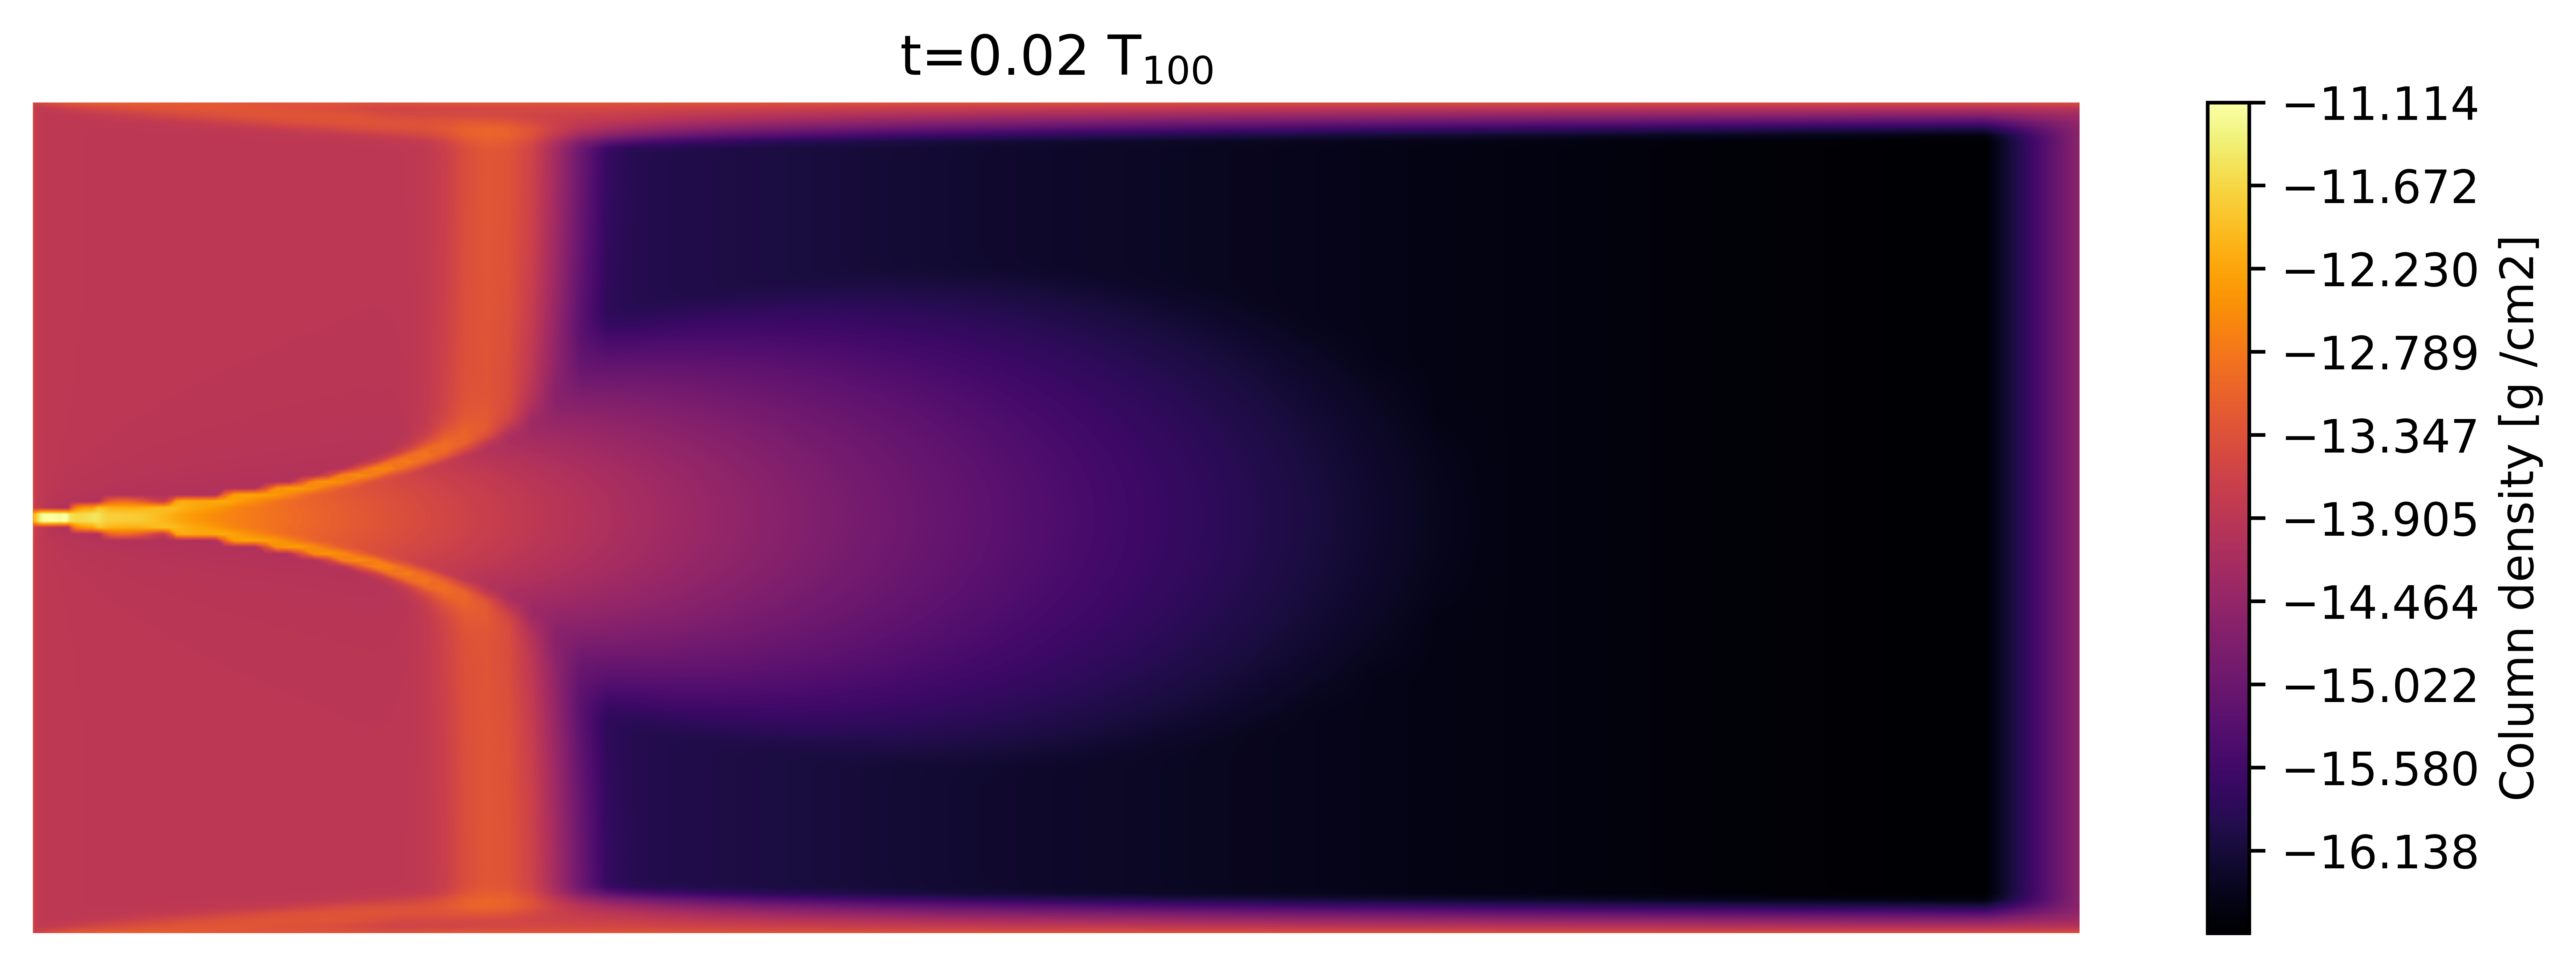

In [12]:
run_test(test='DISK_EDGE-ON')

# Test 7: Accreting protoplanetary disk

This is the same test as above but this time we set an accretion rate of $10^{-7} M_{\odot}/\mathrm{yr}$ at the external boundary. This corresponds to the simulation S7-1 of Lesur et al. (2015). In this test, we expect a shock to reach the disk boundary after about 2000 years. If the test is ran at higher resolution and for a longer time, the Rossby wave instability will trigger at the outskirt of the disk.

In [ ]:
run_test(test='DISK_S7-1')

Here we model the radial drift in a protoplanetary disk. As times goes on, the dust moves inward because it loses momentum as a result of the gas drag.

# Test 8: Dusty protoplanetary disk

In [ ]:
options={'OPENMP':1,"NUM_THREAD":2,'SOLVER':1,'SOLVERDUST':0,"RESOLUTION":64}
run_test(test='DISK_DUST',options=options)

# Test 9: Dusty protoplanetary disk (with Stepinksi growth)

In [ ]:
options={'OPENMP':1,"NUM_THREAD":2,'SOLVER':1,'SOLVERDUST':0,"RESOLUTION":64}
run_test(test='DISK_DUST_STEP',options=options)

# Test 10: Dusty accreting protoplanetary disk

Same, but this time we account for accretion, as above.

In [ ]:
options={'OPENMP':1,"NUM_THREAD":2,'SOLVER':1,'SOLVERDUST':0,"RESOLUTION":128}
run_test(test='DISK_DUST_ACC',options=options)

In [ ]:
options={'OPENMP':1,"NUM_THREAD":4,'SOLVER':1,'SOLVERDUST':0,"RESOLUTION":256}
run_test(test='DISK_PLANET',options=options)
